# TO·Pi·cks:

## Forecast Consumer-Interest in Topics

__Author: Tarun Gupta  
  Company: Insight Data Science  
  Location: Toronto, ON__   
  Date: Januray 2019  
  Github: https://github.com/tguptaMT/TOPicks  
  __About:__ Powered by NLP and machine-learning based time-series forecasting, TO·Pi·cks is a consumer-engagement and popularity forecasting tool. See ReadMe file for more details. 
  
  _This is the second file in a series of Jupyter notebooks associated with TOPicks._

### Step2: Natural Language Processing and Topic-Modelling

- __Load Data:__ 
    - load previously cleaned data from step1 saved in SQLite db.
- __NLP pre-processing:__
    - Tokenize
    - Remove stopwords: 
        - combine different libraries from NLTK, spacy and sklearn
        - add custom lists of stopwords not present in these libraries
    - Remove transparently obvious topics that saturate news cycle, like Trump/Clinton in 2016 data.
- __Feature Engineering:__    
    - Extract custom features:
        - Number of words
        - Number of Sentences
        - Extent of capitailization
        - Day of the week
        - Week of the year,
        - Month of the year etc.
    - Save cleaned up version in a Parquet file format.
- __NMF Topic Modeling:__
    - Train models with a range of 20-400 topics.
    - Compare reconstruction error.
    - Decide how many topics to use balancing topic specificity and having enough data for downstream time-series forecasting.
    - Assign topics to the whole corpus
    - What are different topics about exactly? 
- __Topic Analytics:__
    - What's the size of each topic cluster?
    - How do different topics compare in their popularity and user-engagement?
- __Train Word2vec:__
    - In order to:
        - find synonyms to user-input (recommend related-topics)
        - Build a string of top 10 synonyms to feed to NMF model for matching user-input to topic cluster 

In [2]:
import os
import re
import glob
import sqlite3
from joblib import dump, load
import pandas as pd

import squarify # squares the data based on value
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt

import nltk
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import warnings
warnings.simplefilter("ignore")

#### Define Functions

In [3]:
#################### GENERAL FUNCTIONS ####################

def import_from_sql(db_name, tb_name, action='import'):
    """
    Input:
        db_name: Location+name of the SQLite3 db
        tb_name: Name of the table within the db
    Function:
        Import tables from a sqlite3 database.
    Output: Pandas DataFrame.
    """
    
    data = pd.DataFrame()
    if os.path.exists(db_name):
        print("\nFound", db_name)
        conn = sqlite3.connect(db_name)
    else:
        print("\nNOT Found", db_name)
    
    if conn:
        try:
            cur = conn.cursor()
            if action == 'import':
                data = pd.read_sql('SELECT * FROM {}'.format(tb_name), conn)           # vulnerable to sql injection
            if action == 'drop':
                cur.execute("DROP TABLE {}".format(tb_name))                           # to drop a table
            elif action == 'list':
                cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")     # to view tables in the db
                print(cur.fetchall())
                # cur.execute("ALTER TABLE {} RENAME TO {}".format('data_yk', 'data_yt'))  # for renaming.
            conn.close()
        except:
            print("No table found for: ", tb_name)      
    return data

#------------------------------------------------------#

def safe_division(x,y):
    """ Apply safe division in cases where divisor is 0"""
    if y == 0:
        return 0
    return round((x / y)*100, 2)

#------------------------------------------------------#

#################### NLP RELATED FUNCTIONS ####################

def convert_pos_tag(tag):
    """
    Input: Parts-of-speech tag in Penn TreeBank format.
    Function: convert the first letter of Penn pos-tag to a form NLTK can use
    Output: NLTK-compatible pos-tag.
    """
    pos = {'N' : 'n', 'V' : 'v', 'J' : 'a', 'S' : 's', 'R' : 'r'}
    if tag in pos.keys(): return pos[tag]
    else: return 'n' # everything else = noun.

#------------------------------------------------------#
    
def token_lem_nostop(sentence):
    """
    Input:
        Strings without punctuation or special chars
    Function:
        Breaks sentences into tokens, removes special chars, lowercase,
        and lemmetize after tagging parts-of-speech.
    Dependencies: 
        Local function: convert_pos_tag() function
    """
    tokens = [word.lower() for word in nltk.word_tokenize(sentence) if word.isalpha()]
    tokens_pos = nltk.pos_tag(tokens)
    tokens_lem = [lmtzr.lemmatize(x[0], convert_pos_tag(x[1])) for x in tokens_pos
                 if x[0] not in ['dead', 'died', 'die', 'isis', 'brexit']]
    tokens_nostop_lem = [x for x in tokens_lem 
                         if ((len(x.strip())>=3)&(x not in all_stopwords))]
    return tokens_nostop_lem

#------------------------------------------------------#


def print_top_words(model, feature_names, n_top_words):
    """
    Input:
        MODEL: Trained NMF model with component loadings
        Feature_names: Terms from tf-IDF term (feature) matrix
        n_top_words: the number of top n term associated with a topic
    Function:
        From all the component loadings in topic-term matrix, identify
        and print n top words that represent that topic cluster
    Output:
        No return object. Only local print statement.
    Disclaimer: Modified to add component weights from https://scikit-learn.org/[...]/sklearn.decomposition.NMF.html 
    """

    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += ", ".join([(feature_names[i]+": "+str(round((topic[i]), 2)))
                                 for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    return


#### Load pre-cleaned data from step1:

In [4]:
# Check if composite database already exists for this country and state.
key = 'data_nopv'
db_name = 'data/sql_data/News_headlines_facebook.db'
if os.path.exists(db_name):     
    pilot = import_from_sql(db_name, tb_name=key, action='import')

if not pilot.empty:
    print("Import SQL database", key,"to pandas DataFrame: Done!")
    display(pilot.head())


Found data/sql_data/News_headlines_facebook.db
Import SQL database data_nopv to pandas DataFrame: Done!


,index,date,source,headline,description,likes_count,comments_count,shares_count,post_type,link,id,month
0,31653,2016-08-22 05:34:02,cbs_news,�Thank heaven for Leslie Caron,,487,19,55,link,http://cbsn.ws/2byl7XS,"﻿""131459315949_10153831816295950""",2016-08-27 00:00:00
1,52010,2014-12-05 17:40:10,the_huffington_post,￼15 Hottest Baby Name Trends For 2015,Baby name trends for 2015 signal an increasing...,3583,1038,2179,link,http://www.huffingtonpost.com/2014/12/05/baby-...,"﻿""18468761129_10152663781231130""",2014-12-06 00:00:00
2,22501,2015-05-08 10:48:31,the_new_york_times,완벽한 손톱을 위해 죽어가는 근로자들,"네일 미용을 위해 사용되는 제품 속 많은 성분들이 암, 유산, 폐 질환 및 기타 질...",76,8,12,link,http://nyti.ms/1JTn2kJ,"﻿""5281959998_10150580028089999""",2015-05-05 00:00:00
3,22452,2015-05-07 13:14:21,the_new_york_times,반짝이는 매니큐어에 숨겨진 네일 미용사들의 어두운 삶,뉴욕타임스는 취재 중 많은 네일숍 직원들이 부당한 대우와 인종차별 및 학대에 흔하게...,150,21,59,link,http://nyti.ms/1bAvnuz,"﻿""5281959998_10150579580064999""",2015-05-05 00:00:00
4,18858,2015-02-17 04:42:21,the_new_york_times,那些隐迹于纽约奢华公寓的全球富豪,时代华纳中心的建设引领了一系列俯瞰中央公园的豪华住宅楼的开发。其两座灯火通明的高层公寓楼成为...,75,15,26,link,http://bit.ly/1AxZHBB,"﻿""5281959998_10150535449689999""",2015-02-04 00:00:00


In [5]:
# Clean up the headlines:
import string
def clean_headlines(text):
    # remove website links
    text = re.sub(r'(http://)|([w]{3}[\.])|(\b[\.][\w]{2,3}[\s]*$)', ' ', text)   #remove hyperlinks
    # encode unicode characters to ascii and decode to utf-8 and in that process get rid of special unicode chars
    text = (text.encode('ascii', 'ignore')).decode("utf-8")
    text = remove_punc(text)
    return text

def remove_punc(text):
    text = re.sub(r'(['+string.punctuation+'])', ' ', text)                       
    text = re.sub(r'(#|\"|“|”)', '', text)
    return text

pilot['headline_nopunc'] = pilot['headline'].apply(lambda row: remove_punc(clean_headlines(row)))
pilot = pilot[pilot['headline_nopunc'].map(lambda row: len(row.strip())>1)] # remove empty rows after unicode decoding.
pilot[['headline', 'headline_nopunc']].head(5)

,headline,headline_nopunc
0,�Thank heaven for Leslie Caron,Thank heaven for Leslie Caron
1,￼15 Hottest Baby Name Trends For 2015,15 Hottest Baby Name Trends For 2015
11,“Women of Vision”: A New Generation,Women of Vision A New Generation
12,“Will I do another tour with Paul? Well..',Will I do another tour with Paul Well
13,“What a horrible mother:” How a call from a “g...,What a horrible mother How a call from a good...


### Remove transparently obvious / undesirable news topics

TO·Pi·cks isn't meant to learn to simply reiterate a transparently obvious topic that seemingly saturate the current news cycle. The business use case is to find and compare otherwise well-received topics that aren't trasparently obvious or to assess the likely readership / user-engagement a candidate topic will receive. Therefore, I filtered the corpus by removing documents that pertain to Clinton or Trump since these topics heavily dominated the news during the data collection period.

In [6]:
# there are 17602 articles with trump and clinton news
undesirables = 'clinton | trump'
print("{} posts/headline correspond to {} related topics.".format(len(pilot[pilot['headline_nopunc'].str.\
          contains(undesirables, case=False)]), undesirables))

# select posts that are not related to trump or clinton
pilot = pilot[~pilot['headline_nopunc'].str.contains('clinton | trump', case=False)]

17602 posts/headline correspond to clinton | trump related topics.


### Tokenize | Remove stopwords | Lemmatize

In [7]:
# Create a custom stopwords list
from nltk.corpus import stopwords # convervative (153 stopwords)
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS #(318 sw)
from spacy.lang.en.stop_words import STOP_WORDS #(305 sw)

all_stopwords = list(set(stopwords.words('english')+[x for x in ENGLISH_STOP_WORDS]
                +list(STOP_WORDS)+['say', 'says', 'said', 'mean', 'get', 'big', 
                                   'clinton', 'clintons', 'trump', 'trumps',
                                  'year', 'years', 'ago', 'know', 'thing',
                                  'best', 'like', 'look', 'later', 'hit',
                                  'meet', 'come', 'tell', 'told', 'double', 'got',
                                  'week', 'rule', 'set', 'end', 'going', 'away',
                                  'let', 'long', 'went', 'matter', 'tell', 'told',
                                  'story', 'wrong', 'need', 'hour','late', 'use',
                                  'word', 'take', 'go', 'inside', 'worst', 'worse',
                                  'real', 'live', 'start', 'play', 'role', 'biggest',
                                  'need', 'goes', 'gone', 'opener', 'open', 'stop',
                                  'step', 'dont', 'he', 'she', 'wont', 'youre',
                                  'weve', 'wheres', 'true', 'didnt', 'arent', 'day',
                                   'night', 'daily', 'file'])) 

# While combining different lists of stopwords from different libraries is a 
## great idea, adding multiple forms of potentially lemmetizable stopwords is not.
### It's much better to lemmetize the original string that still has punctuation
#### (like - we've, he'd, 'she's etc.) if the string doesn't have too many special chars


In [8]:
### Lemmatize the tokens:
lmtzr = nltk.WordNetLemmatizer()
pilot['tokens_nostop_lem'] = pilot['headline_nopunc'].apply(
                                        lambda row: token_lem_nostop(row))
pilot['tokens_nostop_lem'].head(10)

0                        [thank, heaven, leslie, caron]
1                                [hottest, baby, trend]
11                     [woman, vision, new, generation]
12                                         [tour, paul]
13    [horrible, mother, good, samaritan, derailed, ...
14                                   [ask, voter, fear]
15                                   [guy, rifle, hell]
16          [subversive, sneaker, meme, explained, old]
17    [brain, horror, incredible, calm, diamond, lav...
18                                      [continue, doe]
Name: tokens_nostop_lem, dtype: object

### Feature Engineering

In [9]:
# What day of the week, what month of the year and what hour of the day is that story published on?
pilot['date'] = pd.to_datetime(pilot['date']).dt.round('S')
pilot['dayofweek'] = pd.to_datetime(pilot['date']).dt.dayofweek
pilot['monthofyear'] = pd.to_datetime(pilot['date']).dt.month
pilot['hourofday'] = pd.to_datetime(pilot['date']).dt.hour

#############################################################
# How many number of stopwords, what is the extent of capitalization, punctuation etc.

pilot['num_sent'] = pilot['headline'].apply(lambda row: len( nltk.tokenize.sent_tokenize(row)))

# Do the total number of words (including stopwords) in a headline correspond to it's popularity?
pilot['num_all_words'] = pilot['headline_nopunc'].apply(lambda row: len(row.split()))


# Does the % of characters that are punctuation correspond to the popularity of a headline?
pilot['%_punc'] = pilot['headline'].apply(lambda row: 
                        safe_division(len([x for y in re.findall(r'((['+string.punctuation+'])|(#|\"|“|”))', row) for x in y])
                           ,len([x for x in row])))


# Does the extent (% of chars) of capitalization associate with popularity of a headline?
pilot['%_caps'] = pilot['headline_nopunc'].apply(lambda row: safe_division(len([x for y in re.findall(r'[A-Z]', row) for x in y])
                              ,len([x for y in re.findall(r'[a-zA-Z]', row) for x in y])))

# Does the fraction of stopwords in a headline correspond to it's popularity?
pilot['%_stop_words'] = pilot['headline_nopunc'].apply(lambda row: 
                            safe_division(len([word for word in row.split() if word in all_stopwords]),\
                               len(row.split())))


#### Save Token Data and Engineered Features to Parquet

In [10]:
# As the Df contains heterogenous data with different dtypes and objects,
# serialize with parquet. Other formats like joblib or pickle are too slow/big and 
## hdf5 has issues with mixed dtypes. Use pyarrow engine in parquet 
### because of this benchmark: http://wesmckinney.com/blog/python-parquet-update/

# Drop unnecessay columns before saving
pilot.drop(columns=['index', 'id', 'description', 'link'], inplace=True)
print(pilot.keys())

pilot.to_parquet('data/parquet_data/news_fb_tokenized.parquet', engine='pyarrow')

Index(['date', 'source', 'headline', 'likes_count', 'comments_count',
       'shares_count', 'post_type', 'month', 'headline_nopunc',
       'tokens_nostop_lem', 'dayofweek', 'monthofyear', 'hourofday',
       'num_sent', 'num_all_words', '%_punc', '%_caps', '%_stop_words'],
      dtype='object')


### Topic Modeling: Identify topic categories for each headline

Broadly, I can envison all news headlines to fall into following categories: a) Politics, b) sports, c) entertainment, d) crime, e) science and technology, f) economy / stock market, g) war / international politics etc. But these are rather broad topics not useful for forecasting what to write about. In order to get both broader categories as well as more granular topic categories, I tried hLDA with 3 levels depth. It ended up segmenting the 374,000 documents into 2000+ topics which is far too may for downstream forecasting of each individual topic. Therefore, I need to stick with single layer LDA/NMF and select topics based on metrics like topic coherence or reconstruction error.

I also ended up spending a couple of days running parameter gridsearch on LDA and not getting any meaningful topics. My conclusion is that LDA just doesn't work well for documents that are too short like 1-2 sentence long headlines in this case. So, I'll focus my efforts on optimizing the number of topics in NMF henceforth.

#### Non-Negative Matrix Factorization

In [81]:
vectzr = 'tfidf' #options: tf, tfidf
n_samples = len(pilot)
n_features = 50000
n_top_words = 10
ngrams= (1, 3) # problem with only 2,3 ngram vocab is that in many cases 
               ## there isn't enough representation of those tokens in my documents
               ### which is news headlines (i.e. short text).
               #### So, most of the documents would get lumped in one broad topic.

#######################################################

print("Loading dataset...")
t0 = time()
data_samples = [" ".join(x) for x in pilot['tokens_nostop_lem'].values]
print("done in %0.3fs." % (time() - t0))

#######################################################
# Use tf/tf-idf features for NMF.
print("Extracting "+str(vectzr)+" features for NMF...")
if vectzr == 'tfidf':
    vectorizer = TfidfVectorizer(max_df=0.20, min_df=5,
                                   ngram_range=ngrams,
                                   max_features=n_features)
if vectzr == 'tf':
    vectorizer = CountVectorizer(max_df=0.20, min_df=5,
                                   ngram_range=ngrams,
                                   max_features=n_features)

t0 = time()
tfvectorized = vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

for n_topics in tqdm([25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350, 400]):
    #######################################################
    # Fit the NMF model
    """When using random initialisation, the results can be different
    every time NMF is applied to the same data. More reliable results
    can be obtained if you initialise with SVD (Belford et al, 2018).
    """
    print("Fitting the NMF model (Frobenius norm) with "+str(vectzr)+" vectorization of "+
          str(n_samples)+" samples and "+str(n_features)+" features...")
    t0 = time()
    nmf = NMF(n_components=n_topics, alpha=.1, l1_ratio=.5, init="nndsvd") #svd init is more stable than random for large data
    W = nmf.fit_transform(tfvectorized)   # W factor contains document membership weights across the k topics. 
                                   # Each row corresponds to a different document, each column corresponds to a topic.

    H = nmf.components_   #contains term weights relative to each of the k topics. Each row corresponds to a topic, 
                          #each column corresponds to a unique term in the corpus vocabulary.

    print("done in %0.3fs." % (time() - t0))

    #######################################################
    # DUMP TRAINED MODEL
    for k, v in {'nmf': nmf, str(vectzr): vectorizer, 'W': W}.items():
        model_name = 'model/nmf/latest_'+str(k)+'_'+str(vectzr)+'_ntop-'+str(n_topics)+\
                     '_nftr_'+str(n_features)+'_ngrams_'+str(ngrams)+'_.joblib'

        print("Exporting: ", model_name)
        dump(v, model_name)

Loading dataset...
done in 0.201s.
Extracting tfidf features for NMF...


  0%|          | 0/2 [00:00<?, ?it/s]

done in 27.232s.
Fitting the NMF model (Frobenius norm) with tfidf vectorization of 355850 samples and 50000 features...
done in 3043.676s.
Exporting:  model/nmf/latest_nmf_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib
Exporting:  model/nmf/latest_tfidf_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib
Exporting:  model/nmf/latest_W_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib


 50%|█████     | 1/2 [51:12<51:12, 3072.60s/it]

Fitting the NMF model (Frobenius norm) with tfidf vectorization of 355850 samples and 50000 features...
done in 5436.949s.
Exporting:  model/nmf/latest_nmf_tfidf_ntop-250_nftr_50000_ngrams_(1, 3)_.joblib
Exporting:  model/nmf/latest_tfidf_tfidf_ntop-250_nftr_50000_ngrams_(1, 3)_.joblib
Exporting:  model/nmf/latest_W_tfidf_ntop-250_nftr_50000_ngrams_(1, 3)_.joblib


100%|██████████| 2/2 [2:22:09<00:00, 3787.96s/it]


#### Choose optimal number of NMF topics

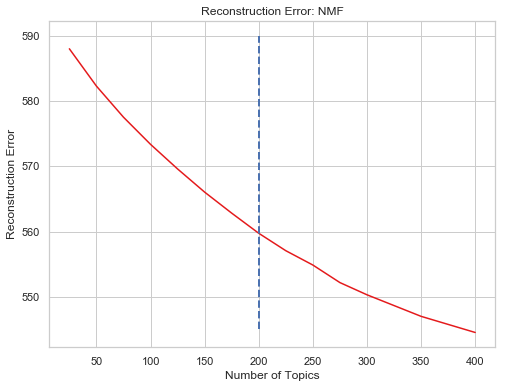

In [11]:
# Plot reconstruction error against the number of topics
## Decide on the number of topics not just based on recon error
### but also if the topics make intuitive / human sense as well
### Also consider if I'd be spreading myself too thin insopfar
#### as having enough data for time series analysis is concerned.

x, y = [], []
# Select previously trained models for examination:
for nt in [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350, 400]:
    f_name = glob.glob('model/nmf/*nmf_tfidf_ntop-'+str(nt)+'_nftr_50000_ngrams_(1, 3)_.joblib')[0]
    nmf_ = load(f_name) 
    x.append(nt)
    y.append(nmf_.reconstruction_err_)
    
sns.set(style="whitegrid")
sns.set_palette(sns.color_palette("Set1"))
plt.rc('figure', figsize=(8, 6))
plt.plot(x, y)
plt.title("Reconstruction Error: NMF")
plt.xlabel("Number of Topics")
plt.ylabel("Reconstruction Error")
plt.plot([200, 200], [545, 590], 'b--', lw=2)


Ideally I'd like to increase granularity of my topics and have very specific topic clusters by minimizing the reconstruction error as much as possible. However, that doesn't leave me with enough data to work with in a meaningful way for downstream time-series analaysis. For example, after filtering out topics that already saturate the market like the ones related to Trump, selecting x=300 topic clusters leaves me with ~1000 datapoints per topic spread over a period of 5 years with the smallest cluster containing only 43 datapoints. From this, I will also need to hold out validation and test datasets. So, I can't afford to be too granular and will have to accept some degree of generality. Selecting x=200 provides a reasonable balance between generality and granularity while providing me with ~1600 datapoints per topic and at least 500 data points in the smallest cluster (based on analysis not shown here.)

### Assign NMF Topics to Documents:

In [12]:
############## load previously trained model ##############
nmf = load('model/nmf/latest_nmf_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib') 
vectorizer = load('model/nmf/latest_tfidf_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib')
W = load('model/nmf/latest_W_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib')

# Extract feature names
feature_names = vectorizer.get_feature_names()

#Assign text labels to topic numbers by first 2 words that represent the topic:
# These words do not tightly define the topic of the headline.
all_topics = {}
for idx, topic in enumerate(nmf.components_):
    all_topics[idx] = [' | '.join(set(' '.join([(vectorizer.get_feature_names()[i])\
                        for i in topic.argsort()[:-2 - 1:-1]]).split()))][0]

# Extract corresponding component values for each headline
text = [" ".join(x) for x in pilot['tokens_nostop_lem'].values]
pilot['predicted_topic'] = [W[x].argmax() for x in range(0, len(text))]
pilot['topic_name'] = pilot['predicted_topic'].apply(lambda x: all_topics[x])

#### Save Token Data and Engineered Features to Parquet

In [14]:
# Save topic assignments to local file
pilot.to_parquet('data/parquet_data/step2_NMF_topics='+str(len(all_topics))+'_assigned.parquet', engine='pyarrow')


### What are the topics about?

In [15]:
n_top_words = 10
print("\nTopics in NMF model (Frobenius norm):")
feature_names = vectorizer.get_feature_names()
print_top_words(nmf, feature_names, n_top_words=n_top_words)


Topics in NMF model (Frobenius norm):

Topic #0: new: 12.4, new jersey: 0.49, jersey: 0.49, new hampshire: 0.48, hampshire: 0.48, new orleans: 0.4, orleans: 0.4, new zealand: 0.36, zealand: 0.36, new study: 0.32

Topic #1: woman: 11.75, pregnant: 0.46, pregnant woman: 0.38, old woman: 0.26, young woman: 0.18, black woman: 0.18, birth: 0.17, men woman: 0.17, woman want: 0.16, husband: 0.16

Topic #2: obama: 11.1, president obama: 0.93, michelle: 0.69, michelle obama: 0.68, administration: 0.44, obama administration: 0.43, immigration: 0.39, visit: 0.31, barack: 0.27, barack obama: 0.25

Topic #3: world: 10.81, world series: 0.64, series: 0.63, oldest: 0.4, largest: 0.4, world war: 0.39, world oldest: 0.37, world largest: 0.36, world record: 0.26, world leader: 0.24

Topic #4: cup: 4.92, world cup: 3.95, final: 0.72, world: 0.5, coffee: 0.47, brazil: 0.46, woman world cup: 0.44, germany: 0.44, woman world: 0.42, cup final: 0.4

Topic #5: cbs: 4.76, cbs news: 4.25, news: 3.7, morning: 2.

### Explore the corpus by topics

In [16]:
# How many documents are distributed in what topic
topic_dist = pilot.groupby(['predicted_topic'])['headline_nopunc'].count()
topic_dist.describe()

count      199.000000
mean      1788.190955
std       1796.946696
min        587.000000
25%       1288.000000
50%       1621.000000
75%       1985.000000
max      25960.000000
Name: headline_nopunc, dtype: float64

587 3559 <class 'int'> <class 'int'>


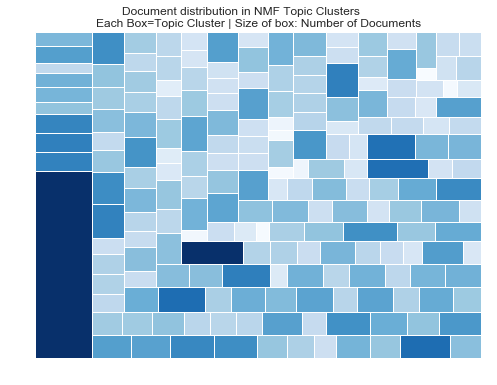

In [17]:
# Visual depiction of the size of the topic clusters
topic_dist = topic_dist\
        .reset_index(name='Counts')
#         .sort_values('Counts', ascending=False)

cmap = matplotlib.cm.Blues
mini=min(topic_dist.Counts)
maxi=max(topic_dist.Counts[1:])
print(mini, maxi, type(mini), type(maxi))
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in topic_dist.Counts]

plt.rc('figure', figsize=(8, 6))
display(squarify.plot(sizes=topic_dist.Counts, alpha=1, color=colors));
plt.title("Document distribution in NMF Topic Clusters\
          \nEach Box=Topic Cluster | Size of box: Number of Documents");
plt.axis('off');
plt.show()

__Comments:__  

Most of the topic clusters are somewhat evenly sized except topic#0 - the biggest box in the gchart above. As you examine this distribution and the document topic assignment below, consider that:
- The topics that do not get categorized in any other specific category seem to be lumped into a miscellaneous class represented by topic 0, the largest box in the squareplot above. This misc. topic cluster 0 will not be included for the downtream time-series analysis purposes. 
    - Such lumping happens because quite likely these documents / headlines contain some rare words that were not used as features by the tfidf as a frequency based minimum cut-off point was used to restrict the size of the tfidf feature matrix. 
    - When the number of topics is increased to minimize the reconstruction error, the size of this misc. cluster 0 decreases and the specificity of topic increases significantly.
- Words selected to represent topic clusters are only two of the top 10 components (or topics) each headline corresponds to. So, they shouldn't be viewed as tight granular descriptions of the topic, although in many cases they are. For instance, topic 136: 'paul | ryan' isn't *only* about that ex-US speaker named Paul Ryan; but about both Paul AND Ryan, and about 8 other associated terms not explicitly indicated here. Similarly #84: 'mother | teresa' is about both mothers as well as mother teresa
- It's obvious that selecting 200 topics as opposed to 400 introduces some level of generality as well as mis-classification in topic clustering. Extent of such intrusion can be tested with coherence test implemented in gensim.

In [18]:
pd.set_option('display.max_colwidth', 100)
pilot[['headline_nopunc', 'predicted_topic', 'topic_name']].head(50)

,headline_nopunc,predicted_topic,topic_name
0,Thank heaven for Leslie Caron,0,new | jersey
1,15 Hottest Baby Name Trends For 2015,42,born | baby
11,Women of Vision A New Generation,1,pregnant | woman
12,Will I do another tour with Paul Well,136,paul | ryan
13,What a horrible mother How a call from a good samaritan derailed these mothers lives,84,mother | teresa
14,What Is the EU Ask U K Voters EU Fears Others Dont Know,113,answer | question
15,Weve got a guy with a long rifle We dont know where the hell hes at,133,bad | news
16,WHAT ARE THOSE a subversive sneaker meme explained for the Olds,15,old | girl
17,This is the brain on horror the incredible calm of Diamond Lavish Reynolds,181,brain | scientist
18,These things will continue until someone does something,97,baby | doe


(Text(0.5,1,'Median User-Engagement / topic'),)

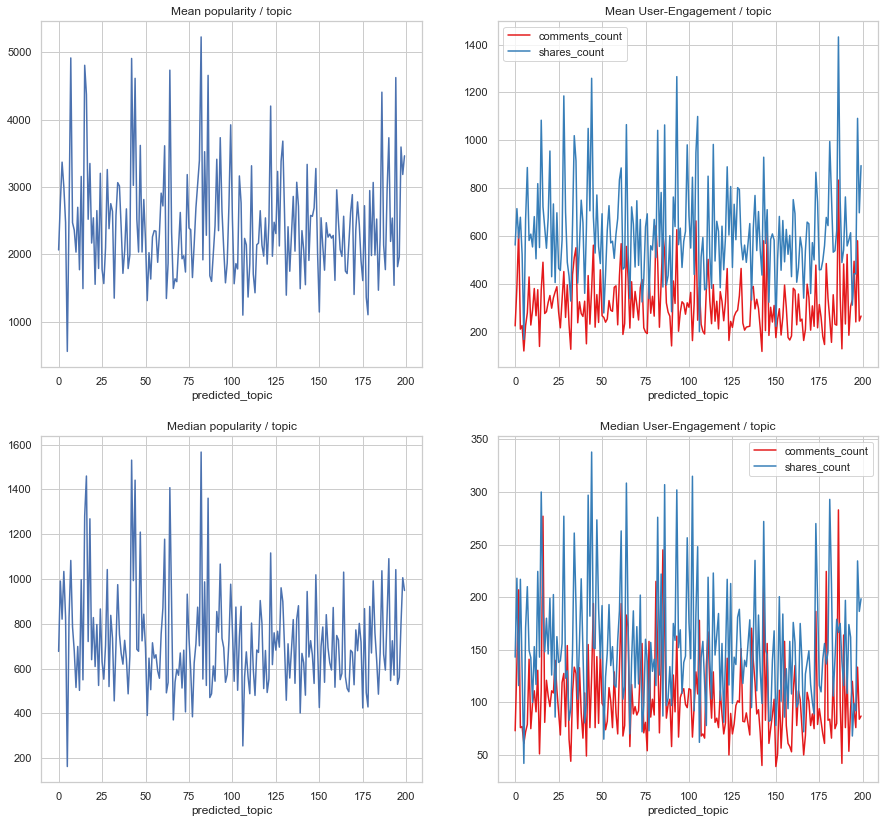

In [20]:
# Visualize each topic by popularity and user engagement
## Consider plotting this as catergorical scatterplots with glyphs

plt.rc('figure', figsize=(15, 14))
pilot.groupby(['predicted_topic'])['likes_count'].mean().plot(
                                                    ax=plt.subplot(221), color='b')
plt.title("Mean popularity / topic"), 
# Visualize each topic by popularity and user engagement
pilot.groupby(['predicted_topic'])['comments_count', 'shares_count'].mean()\
                                                    .plot(ax=plt.subplot(222))
plt.title("Mean User-Engagement / topic"), 

pilot.groupby(['predicted_topic'])['likes_count'].median().plot(
                                                    ax=plt.subplot(223), color='b')
plt.title("Median popularity / topic"), 
# Visualize each topic by popularity and user engagement
pilot.groupby(['predicted_topic'])['comments_count', 'shares_count'].median()\
                                                    .plot(ax=plt.subplot(224))
plt.title("Median User-Engagement / topic"), 

__Observations:__

- Looking at these figures, it's clear that some topic are much more popular and engaging than others when examined in aggregate from 2012-2017. 
- __How does this popularity ebb and flow through time?__ Are there systematic temporal variations in popularity of certain topics? 
- If so, __can I build a tool to help content-makers and writers decide when might be the best time-period to create content about a certain topic? __

I will try to address these question in step3_time_series_forecasting.ipynb

#### Train Word2Vec for Synonyms:

In [ ]:
w2vdoc = [list(x) for x in pilot['tokens_nostop_lem']]
bigram = gensim.models.Phrases(w2vdoc, min_count=3, delimiter=b' ')
w2vdoc = [bigram[line] for line in w2vdoc] 
            #this will ensure that user can input bigrams and get results.

w2v = gensim.models.Word2Vec(w2vdoc, size=100, window=5, min_count=3, workers=4)
w2v.train(w2vdoc,total_examples=len(w2vdoc), epochs=10)
w2v.save('model/word2vec/w2v_bigram.model')